# Libraries

### Install

In [ ]:
# install calmap
! pip install calmap

### Import

In [1]:
# essential libraries
import random
from datetime import timedelta  

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap
import folium

# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML

# Dataset

In [ ]:
# list files
# !ls ../input/corona-virus-report

In [5]:
# importing datasets
full_table = pd.read_csv('covid_19_clean_complete.csv', 
                         parse_dates=['Date'])
full_table.sample(6)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
3186,NaN,Montenegro,42.500000,19.300000,2020-02-03,0,0,0
3609,Zhejiang,China,29.183200,120.093400,2020-02-05,895,0,78
13060,NaN,Tanzania,-6.369000,34.888800,2020-03-13,0,0,0
13910,Beijing,China,40.182400,116.414200,2020-03-17,456,8,369
8287,NaN,United Kingdom,55.378100,-3.436000,2020-02-23,9,0,8
8559,NaN,Saint Kitts and Nevis,17.357822,-62.782998,2020-02-24,0,0,0


In [6]:
# dataframe info
full_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16884 entries, 0 to 16883
Data columns (total 8 columns):
Province/State    5226 non-null object
Country/Region    16884 non-null object
Lat               16884 non-null float64
Long              16884 non-null float64
Date              16884 non-null datetime64[ns]
Confirmed         16884 non-null int64
Deaths            16884 non-null int64
Recovered         16884 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.0+ MB


In [7]:
# checking for missing value
full_table.isna().sum()

Province/State    11658
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

# Preprocessing

### Cleaning Data

In [8]:
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[cases] = full_table[cases].fillna(0)

# fixing datatypes
full_table['Recovered'] = full_table['Recovered'].astype(int)

full_table.sample(6)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
4218,,Romania,45.9432,24.9668,2020-02-07,0,0,0,0
14220,French Polynesia,France,-17.6797,149.4068,2020-03-18,3,0,0,3
8961,,Kazakhstan,48.0196,66.9237,2020-02-26,0,0,0,0
16109,,Grenada,12.1165,-61.6790,2020-03-25,1,0,0,1
9010,,Saint Vincent and the Grenadines,12.9843,-61.2872,2020-02-26,0,0,0,0
11540,,South Africa,-30.5595,22.9375,2020-03-07,1,0,0,1


### Derived Tables

In [9]:
# cases in the ships
ship = full_table[full_table['Province/State'].str.contains('Grand Princess')|full_table['Country/Region'].str.contains('Diamond Princess')]

# china and the row
china = full_table[full_table['Country/Region']=='China']
row = full_table[full_table['Country/Region']!='China']

# latest
full_latest = full_table[full_table['Date'] == max(full_table['Date'])].reset_index()
china_latest = full_latest[full_latest['Country/Region']=='China']
row_latest = full_latest[full_latest['Country/Region']!='China']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

# Latest Data

### Latest Complete Data

In [10]:
temp = full_table.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered', 'Active'].max()
# temp.style.background_gradient(cmap='Reds')

### Latest Condensed Data

In [11]:
temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)
temp['Global Moratality'] = temp['Deaths']/temp['Confirmed']
temp['Deaths per 100 Confirmed Cases'] = temp['Global Moratality']*100
temp.style.background_gradient(cmap='Pastel1')

,Date,Confirmed,Deaths,Recovered,Active,Global Moratality,Deaths per 100 Confirmed Cases
0,2020-03-28 00:00:00,660706,30652,138949,491105,0.0463928,4.63928


In [12]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [13]:
tm = temp.melt(id_vars="Date", value_vars=['Active', 'Deaths', 'Recovered'])
fig = px.treemap(tm, path=["variable"], values="value", height=400, width=600,
                 color_discrete_sequence=[act, rec, dth])
fig.data[0].textinfo = 'label+text+value'
fig.show()

# Country wise Data

### In each country

In [14]:
temp_f = full_latest_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f[['Country/Region', 'Confirmed', 'Active', 'Deaths', 'Recovered']]
temp_f = temp_f.reset_index(drop=True)

temp_f.style.background_gradient(cmap="Blues", subset=['Confirmed', 'Active'])\
            .background_gradient(cmap="Greens", subset=['Recovered'])\
            .background_gradient(cmap="Reds", subset=['Deaths'])

,Country/Region,Confirmed,Active,Deaths,Recovered
0,US,121478,118380,2026,1072
1,Italy,92472,70065,10023,12384
2,China,81999,3600,3299,75100
3,Spain,73235,54968,5982,12285
4,Germany,57695,48781,433,8481
5,France,38105,30064,2317,5724
6,Iran,35408,21212,2517,11679
7,United Kingdom,17312,16140,1021,151
8,Switzerland,14076,12282,264,1530
9,Netherlands,9819,9173,640,6


### Countries with Death reported

In [15]:
temp_flg = temp_f[temp_f['Deaths']>0][['Country/Region', 'Deaths']]
temp_flg['Deaths / 100 Cases'] = round((temp_f['Deaths']/temp_f['Confirmed'])*100, 2)
temp_flg.sort_values('Deaths', ascending=False).reset_index(drop=True).style.background_gradient(cmap='Reds')

,Country/Region,Deaths,Deaths / 100 Cases
0,Italy,10023,10.84
1,Spain,5982,8.17
2,China,3299,4.02
3,Iran,2517,7.11
4,France,2317,6.08
5,US,2026,1.67
6,United Kingdom,1021,5.9
7,Netherlands,640,6.52
8,Germany,433,0.75
9,Belgium,353,3.86


# Maps

### Across the world

In [16]:
# World wide

m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=4, zoom_start=1)

for i in range(0, len(full_latest)):
    folium.Circle(
        location=[full_latest.iloc[i]['Lat'], full_latest.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(full_latest.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(full_latest.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(full_latest.iloc[i]['Confirmed'])+
                    '<li><bold>Deaths : '+str(full_latest.iloc[i]['Deaths']),
        radius=int(full_latest.iloc[i]['Confirmed'])**1.1).add_to(m)
m

In [17]:
# Confirmed
fig = px.choropleth(full_latest_grouped, locations="Country/Region", 
                    locationmode='country names', color=np.log(full_latest_grouped["Confirmed"]), 
                    hover_name="Country/Region", hover_data=['Confirmed'],
                    color_continuous_scale="Sunsetdark", 
                    title='Countries with Confirmed Cases')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [18]:
# Deaths
temp = full_latest_grouped[full_latest_grouped['Deaths']>0]
fig = px.choropleth(temp, 
                    locations="Country/Region", locationmode='country names',
                    color=np.log(temp["Deaths"]), hover_name="Country/Region", 
                    color_continuous_scale="Peach", hover_data=['Deaths'],
                    title='Countries with Deaths Reported')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [19]:
formated_gdf = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
                     color="Confirmed", size='size', hover_name="Country/Region", 
                     range_color= [0, max(formated_gdf['Confirmed'])+2], animation_frame="Date", 
                     title='Spread over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

# Cases over the time

In [20]:
temp = full_table.groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
temp.head()

fig = px.area(temp, x="Date", y="Count", color='Case', height=800,
             title='Cases over time', color_discrete_sequence = [rec, dth, act])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [21]:
# ------------------------------------------------------------------------------------------

temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
temp['No. of Deaths to 100 Confirmed Cases'] = round(temp['Deaths']/temp['Confirmed'], 3)*100
temp['No. of Recovered to 100 Confirmed Cases'] = round(temp['Recovered']/temp['Confirmed'], 3)*100

fig_1 = px.area(temp, x="Date", y="Confirmed", color_discrete_sequence = [act])
fig_2 = px.area(temp, x="Date", y="Deaths", color_discrete_sequence = [dth])
fig_3 = px.line(temp, x="Date", y="No. of Deaths to 100 Confirmed Cases",  color_discrete_sequence=['#333333'])
fig_4 = px.line(temp, x="Date", y="No. of Recovered to 100 Confirmed Cases",  color_discrete_sequence=['#0f4c75'])

# ------------------------------------------------

spread = full_table[full_table['Confirmed']!=0].groupby('Date')['Country/Region'].unique().apply(len)
spread = pd.DataFrame(spread).reset_index()

fig_5 = px.line(spread, x='Date', y='Country/Region',  color_discrete_sequence=[dth])

# -------------------------------------------------------------------------------------------

temp = full_table.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan

temp = temp.groupby('Date')['Confirmed'].sum().reset_index()

fig_6 = px.bar(temp, x="Date", y="Confirmed", color_discrete_sequence=['#2a7886'])
fig_6.update_layout(xaxis_rangeslider_visible=True)

# ==========================================================================================

fig = make_subplots(rows=3, cols=2, shared_xaxes=False, vertical_spacing=0.08, horizontal_spacing=0.1,
                    subplot_titles=('Confirmed cases', 'Deaths reported', 
                                    'No. of deaths to 100 Confirmed', 'No. of recovered cases to 100 Confirmed', 
                                    'No. of new countries everyday', 'No. of new cases everyday'))

fig.add_trace(fig_1['data'][0], row=1, col=1)
fig.add_trace(fig_2['data'][0], row=1, col=2)
fig.add_trace(fig_3['data'][0], row=2, col=1)
fig.add_trace(fig_4['data'][0], row=2, col=2)
fig.add_trace(fig_5['data'][0], row=3, col=1)
fig.add_trace(fig_6['data'][0], row=3, col=2)

fig.update_layout(height=1200)

# Top 20 Countries

In [25]:
# Confirmed ==================================================================================================

fig_c = px.bar(flg.sort_values('Confirmed').tail(20), x="Confirmed", y="Country/Region", text='Confirmed', orientation='h')
fig_c.update_traces(marker_color='#000839', opacity=0.8, textposition='auto')
fig_c.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# Deaths ===================================================================================================

fig_d = px.bar(flg.sort_values('Deaths').tail(20), x="Deaths", y="Country/Region",  text='Deaths', orientation='h')
fig_d.update_traces(marker_color='#ff1e56', opacity=0.8, textposition='auto')
fig_d.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# Recovered =================================================================================================

fig_r = px.bar(flg.sort_values('Recovered').tail(20), x="Recovered", y="Country/Region", text='Recovered', orientation='h')
fig_r.update_traces(marker_color=rec, opacity=0.8, textposition='auto')
fig_r.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# Active ====================================================================================================

fig_a = px.bar(flg.sort_values('Active').tail(20), x="Active", y="Country/Region", text='Active', orientation='h')
fig_a.update_traces(marker_color=act, opacity=0.8, textposition='auto')
fig_a.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# Moratality ================================================================================================

fig_m = px.bar(temp_m.sort_values('Mortality Rate').tail(20), x="Mortality Rate", y="Country/Region", text='Mortality Rate', orientation='h')
fig_m.update_traces(marker_color='#00bdaa', opacity=0.8, textposition='auto')
fig_m.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# Per Million People =================================================================================================

fig_p = px.bar(temp_p.sort_values('Confirmed Per Million People').tail(20), x='Confirmed Per Million People', y='Country/Region', orientation='h', text='Confirmed Per Million People')
fig_p.update_traces(marker_color='#2c003e', opacity=0.8, textposition='auto')
fig_p.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

# ==========================================================================================================

fig = make_subplots(rows=3, cols=2, shared_xaxes=False, vertical_spacing=0.08, horizontal_spacing=0.1,
                    subplot_titles=("Confirmed", "Deaths", "Recovered", "Active", "Moratlity rate", "Confirmed cases per Million People"))
fig.add_trace(fig_c['data'][0], row=1, col=1)
fig.add_trace(fig_d['data'][0], row=1, col=2)
fig.add_trace(fig_r['data'][0], row=2, col=1)
fig.add_trace(fig_a['data'][0], row=2, col=2)
fig.add_trace(fig_m['data'][0], row=3, col=1)
fig.add_trace(fig_p['data'][0], row=3, col=2)
fig.update_layout(height=1200, title_text="Top 20")

In [26]:
fig = px.scatter(full_latest_grouped.sort_values('Deaths', ascending=False).iloc[:15, :], 
                 x='Confirmed', y='Deaths', color='Country/Region', size='Confirmed', height=800,
                 text='Country/Region', log_x=True, log_y=True, title='Deaths vs Confirmed')
fig.update_traces(textposition='top center')
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

# Date vs

# Composition of Cases

In [28]:
fig = px.treemap(full_latest.sort_values(by='Confirmed', ascending=False).reset_index(drop=True), 
                 path=["Country/Region", "Province/State"], values="Confirmed", height=700,
                 title='Number of Confirmed Cases',
                 color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

fig = px.sunburst(full_latest.sort_values(by='Deaths', ascending=False).reset_index(drop=True), 
                 path=["Country/Region", "Province/State"], values="Deaths", height=700,
                 title='Number of Deaths reported',
                 color_discrete_sequence = px.colors.qualitative.Prism)
fig.data[0].textinfo = 'label+text+value'
fig.show()

# Calander map

### Number of new cases every day

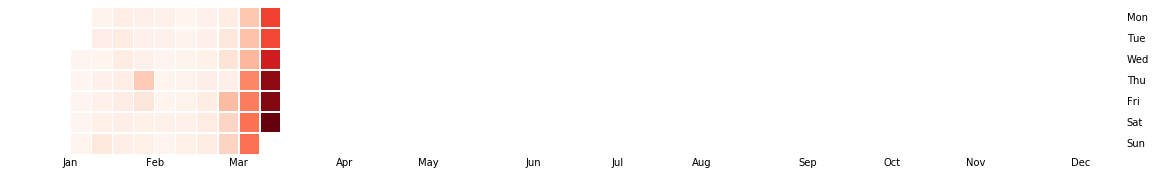

In [32]:
temp = full_table.groupby('Date')['Confirmed'].sum()
temp = temp.diff()

plt.figure(figsize=(20, 5))
ax = calmap.yearplot(temp, fillcolor='white', cmap='Reds', linewidth=0.5)

### Number of new countries every day

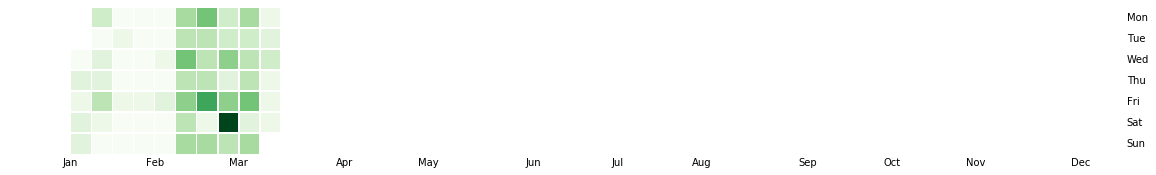

In [33]:
spread = full_table[full_table['Confirmed']!=0].groupby('Date')
spread = spread['Country/Region'].unique().apply(len).diff()

plt.figure(figsize=(20, 5))
ax = calmap.yearplot(spread, fillcolor='white', cmap='Greens', linewidth=0.5)